In [1]:
from iris_lmsalpy import hcr2fits, extract_irisL2data, saveall as sv
import matplotlib.pyplot as plt
import numpy as np
import cv2
from sklearn.cluster import KMeans, MiniBatchKMeans
from ipywidgets import interact

%matplotlib inline



The provided file is a raster IRIS Level 2 data file.

Extracting information from file iris_l2_20151127_002200_3690088076_raster_t000_r00000.fits... 

Available data with size Y x X x Wavelength are stored in windows labeled as:

--------------------------------------------------------------------
Index --- Window label --- Y x X x WL --- Spectral range [Å] (band)
--------------------------------------------------------------------
  0 	 C II 1336    	   389x320x2049 	   1331.68 - 1358.27  (FUV)
  1 	 Si IV 1394   	   389x320x2043 	   1380.68 - 1406.65  (FUV)
  2 	 Mg II k 2796 	   389x320x2033 	   2783.34 - 2835.07  (NUV)
--------------------------------------------------------------------

Observation description: Large dense 320-step raster 105.3x120 320s   Deep x 8 Spatial x 2, S

Creating temporary file...  /var/folders/wf/ym_jh13s78b0s19mm_rnz_xr0000gn/T/tmpwr7xrgjr
Loading joblib file... /Users/aaryan/Documents/Code/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/NIST_2783_2835_

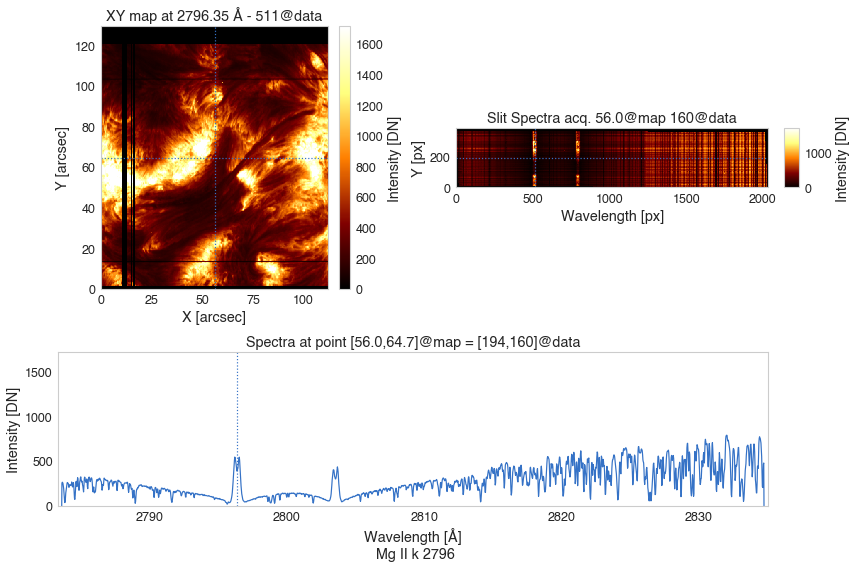

<Figure size 432x288 with 0 Axes>

In [249]:
raster_filename = 'iris_l2_20151127_002200_3690088076_raster_t000_r00000.fits'
iris_raster = extract_irisL2data.load(
    raster_filename, window_info=['Mg II k 2796'], verbose=True
)

iris_raster.quick_look()

In [250]:
mgii = iris_raster.raster['Mg II k 2796']
s = mgii.data.shape

# 560.1213 -> 600
# 74.06597 -> 100
# 25.154545 -> 35
# linear regression -- need more data to actually test
climit = 1.5 * mgii.data.mean() + 5
print(climit)

338.8931655883789


In [251]:
epsilon = 1e-2
first_wl = 2794.00276664
last_wl = 2806.01988627
ps_wl = 2810.58

find_wl_idx = lambda wl: np.where(np.abs(mgii.wl - wl) < epsilon)[0][0]

first_wl_idx = find_wl_idx(first_wl)
last_wl_idx = find_wl_idx(last_wl)
ps_wl_idx = find_wl_idx(ps_wl)
data_bounds = (first_wl_idx, last_wl_idx+1)

best = ps_wl_idx
data_bounds

(419, 892)

[3, 359]
1500 338.8931655883789


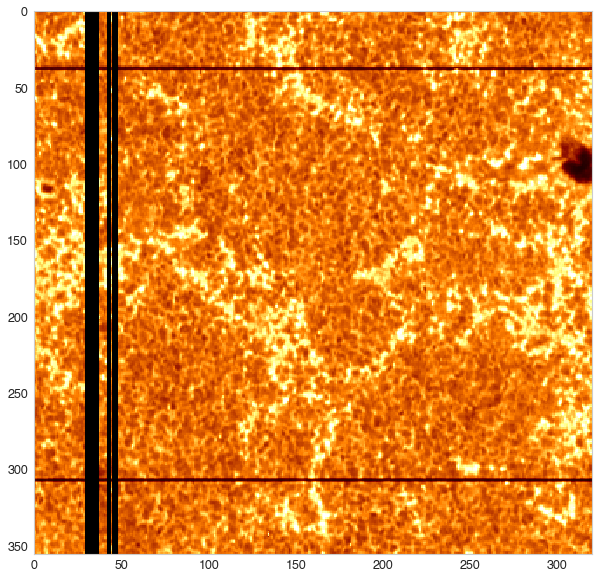

In [252]:
bounds = [0, mgii.data.shape[0]]
for r in range(mgii.data.shape[0]):
    if mgii.data[r].mean() > 0:
        bounds[0] = r
        break

for r in range(mgii.data.shape[0]-1, 0, -1):
    if mgii.data[r].mean() > 0:
        bounds[1] = r
        break

bounds[0] += 1
print(bounds)
data = mgii.data[bounds[0]:bounds[1], :, :]

def remove_outliers(data, m = 3):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

ylimit = (int(remove_outliers(data.max(axis=2)).max() / 100)+1)*100
print(ylimit, climit)

plt.figure(figsize=(10,10))
plt.imshow(data[:, :, best], aspect="auto", cmap=mgii.cmap)
plt.clim([0, climit])

In [253]:
import os
import shutil

dir_name = raster_filename[:-5]
if os.path.exists(dir_name):
    shutil.rmtree(dir_name)
os.makedirs(dir_name)

In [254]:
def create_pixels(masked_image, num_clusters):
    pixels = []
    pixels_loc = []
    for i in range(masked_image.shape[0]):
        for j in range(masked_image.shape[1]):
            if masked_image[i,j]:
                d = data[i, j, :]
                pixels.append(d[data_bounds[0]:data_bounds[1]])
                pixels_loc.append((i,j))
    
    if len(pixels) < num_clusters:
        return (None, None)
    
    pixels = np.stack(pixels, axis=0)
    pixels_loc = np.array(pixels_loc)
    return (pixels, pixels_loc)

In [255]:
def cluster(pixels, num_clusters):
    mbkm = MiniBatchKMeans(
        n_clusters=num_clusters,
        n_init=10
    )

    y_mbkm = mbkm.fit_predict(pixels)

    km = KMeans(
        n_clusters=num_clusters,
        init=mbkm.cluster_centers_,
        n_init=1
    )

    y_km = km.fit_predict(pixels)
    
    return (km, y_km)

In [256]:
def elbow_kmeans(pixels, num_clusters):
    distortions = []
    for i in range(30, 131, 10):
        km = KMeans(
            n_clusters=num_clusters
        )
        km.fit(pixels)
        distortions.append(km.inertia_)
        print(i, end=' ')

    plt.plot(range(30, 131, 10), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()

In [257]:
def generate_kmap(km, y_km, pixels_loc, kmap, num_clusters, kmap_sections, section_idx):
    for c in range(num_clusters):
        in_cluster = pixels_loc[y_km==c]
        x,y = zip(*in_cluster)
        # since kmap needs to be same shape as original to overplot
        kmap[np.array(x)+bounds[0],y,:] = km.cluster_centers_[c]
        kmap_sections[np.array(x)+bounds[0],y,:] = section_idx

In [258]:
def sort_clusters_by_size(y_km, num_clusters):
    counts = []
    for i in range(num_clusters):
        counts.append((i, np.count_nonzero(y_km==i)))

    sorted_counts = sorted(counts, key = lambda i: i[1], reverse=True)
    return sorted_counts

In [259]:
def graph_all_clusters(km, y_km, pixels, sorted_counts, num_clusters, 
                       overlay_all=False, ylim=None, filename=None):
    f, axes = plt.subplots(10, num_clusters//10, sharey=True, sharex=True, figsize=(20,20))
    axes = np.ravel(axes)
    for i in range(num_clusters):
        if overlay_all:
            print(i, end=' ')
            for p in pixels[y_km==i]:
                axes[i].plot(p, c='blue', alpha=0.2)

        axes[i].plot(km.cluster_centers_[sorted_counts[i][0]], c='black', lw=2)
        axes[i].set_title('C{} N{}'.format(sorted_counts[i][0], sorted_counts[i][1]))
        
        if ylim:
            axes[i].set_ylim(ylim)
            
    if filename:
        plt.suptitle(filename[:-4], y=0.95)
        plt.savefig(dir_name+'/'+filename)
    
    plt.show()

In [260]:
def interactive_cluster_slider(y_km, km, pixels_loc, masked_image, num_clusters):
    @interact(c=(0, num_clusters-1))
    def double_number(c):
        in_cluster = pixels_loc[y_km==c]
        y,x = zip(*in_cluster)
        f, axes = plt.subplots(1,2,figsize=(12.8,10))
        axes[0].scatter(x,y, s=1, zorder=1)
        axes[0].set_xlim(0, masked_image.shape[1])
        axes[0].set_ylim(masked_image.shape[0], 0)

        implot = axes[0].imshow(data[:, :, best], cmap=mgii.cmap)
        implot.set_clim([0, climit])

        spec_plot = axes[1].plot(km.cluster_centers_[c])
        axes[1].set_ylim([0, ylimit])

In [261]:
def run_clustering(w, num_clusters, filename, kmap, kmap_sections, section_idx, calc_super, black_mask, m=None):
    masked_image, super_penumbra, quiet = clean_image(w, calc_super, black_mask, m)
    print('Done masking')
    pixels, pixels_loc = create_pixels(masked_image, num_clusters)
    print('Done creating pixels')
    
    if pixels is None:
        return None
    
    km, y_km = cluster(pixels, num_clusters)
    print('Done clustering')
    # elbow_kmeans(pixels, num_clusters)
    generate_kmap(km, y_km, pixels_loc, kmap, num_clusters, kmap_sections, section_idx)
#     sorted_counts = sort_clusters_by_size(y_km, num_clusters)
#     graph_all_clusters(km, y_km, pixels, sorted_counts, num_clusters, ylim=(0,ylimit), filename=filename)
    # interactive_cluster_slider(y_km, km, pixels_loc, masked_image, num_clusters)
    
    return (masked_image, super_penumbra, quiet, km)

In [262]:
def clean_image(w, calc_super, black_mask, m):
    ret, masked_image = cv2.threshold(w, 0, 255, cv2.THRESH_BINARY)
    
    masked_image = masked_image.astype(np.uint8)
    masked_image &= black_mask
    
    print("ORIGINAL")
    plt.figure(figsize=(10,10))
    plt.imshow(masked_image, aspect="auto")
    plt.show()
    
    
    kernel = np.ones((3, 3), np.uint8)
    masked_image = cv2.morphologyEx(masked_image, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    print("AFTER CLOSE")
    plt.figure(figsize=(10,10))
    plt.imshow(masked_image, aspect="auto")
    plt.show()
    
    super_penumbra = None
    quiet = None
    
    thresh = masked_image.astype(np.uint8)
    cnts, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    test = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)
    cv2.drawContours(test,cnts,-1,(255,0,0),1)
    plt.figure(figsize=(10,10))
    plt.imshow(test, aspect="auto")
    plt.show()
    
    for cnt in cnts:
        hull = cv2.convexHull(cnt)
        cv2.drawContours(thresh,[hull],-1,255,-1)
    
    print("AFTER FILL")
    plt.figure(figsize=(10,10))
    plt.imshow(thresh, aspect="auto")
    plt.show()
    
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, np.ones((11, 3), np.uint8), iterations=1)
    
    print("THRESH")
    plt.figure(figsize=(10,10))
    plt.imshow(thresh, aspect="auto")
    plt.show()
    
    masked_image &= thresh
    
    plt.figure(figsize=(10,10))
    plt.imshow(masked_image, aspect="auto")
    plt.show()
    c = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
    
    if cv2.contourArea(c) < 50:
        return (np.zeros(masked_image.shape, dtype=np.uint8), super_penumbra, quiet)
    
    if calc_super:   
        cnts, hierarchy = cv2.findContours(masked_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2:]
        draw = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
        ellipse_mask = np.zeros(thresh.shape).astype(np.uint8)
        contour_mask = np.zeros(thresh.shape).astype(np.uint8)
        for c in cnts:
            area = cv2.contourArea(cv2.convexHull(c))
            
            x,y,w,h = cv2.boundingRect(c)
            w_scale = w / thresh.shape[1]
            h_scale = h / thresh.shape[0]
            print(x, y, w, h, w_scale, h_scale, min(w_scale, h_scale) / max(w_scale, h_scale))
            cv2.rectangle(draw,(x,y),(x+w,y+h),(0,255,0),2)
            
            print(area, thresh.size, area/thresh.size)
            
            if (area/thresh.size) > 0.001 and min(w_scale, h_scale) / max(w_scale, h_scale) > 0.25:
                cv2.drawContours(draw, [c], -1, (0,255,0, 1))
                ellipse = cv2.fitEllipse(c)
                center, r, ang = ellipse
                # print(center, r, ang)
                new_ellipse = (center, (r[0]*2.7, r[1]*2.7), ang)
#                 cv2.ellipse(draw,ellipse,(255,0,0),1)
#                 cv2.ellipse(draw,new_ellipse,(255,0,0),1)

                # -1 thickness causes it to be filled in
                cv2.ellipse(ellipse_mask,new_ellipse,255,-1)
                cv2.drawContours(contour_mask, [c], -1, 255, -1)
        
        plt.figure(figsize=(10,10))
        plt.imshow(draw, aspect="auto")
        plt.show()
        
        super_penumbra = ~contour_mask & ellipse_mask
        quiet = ~ellipse_mask
        
    if m is not None:
        masked_image &= m
    masked_image = masked_image.astype(np.float32)
    
    print("FINAL")
    plt.figure(figsize=(10,10))
    plt.imshow(masked_image, aspect="auto")
    plt.show()
    
    return (masked_image, super_penumbra, quiet)

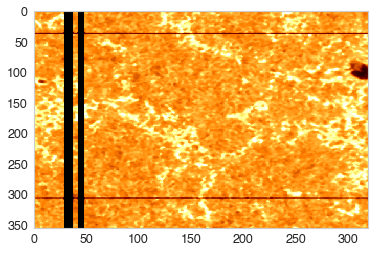

umbra
ORIGINAL


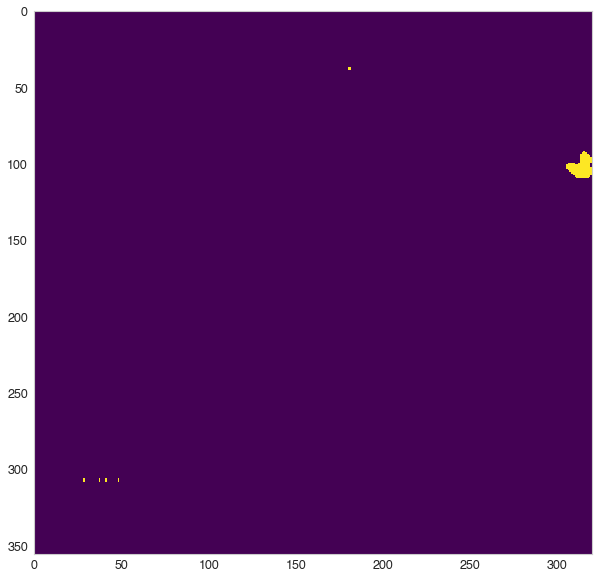

AFTER CLOSE


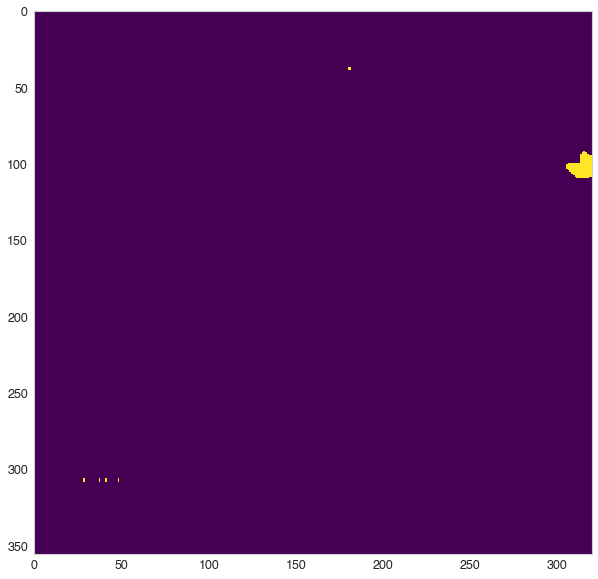

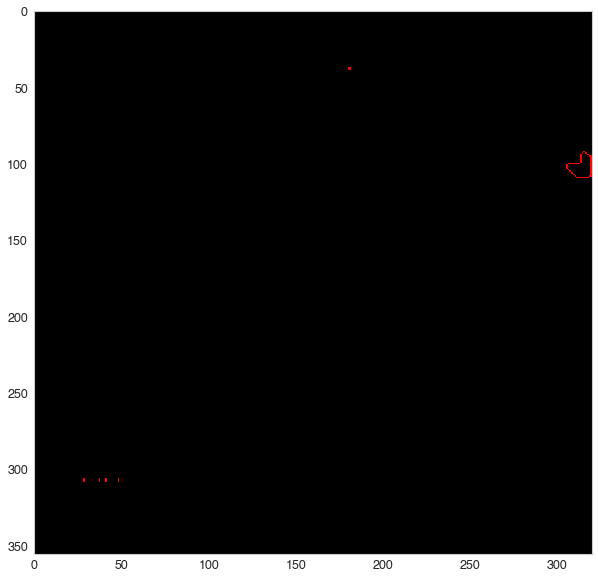

AFTER FILL


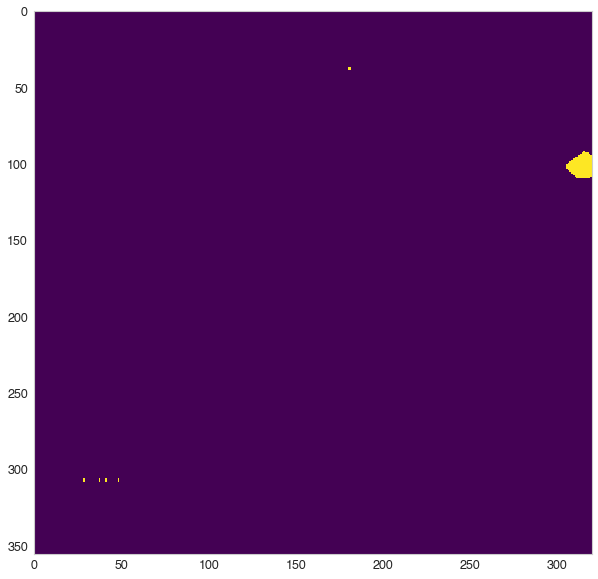

THRESH


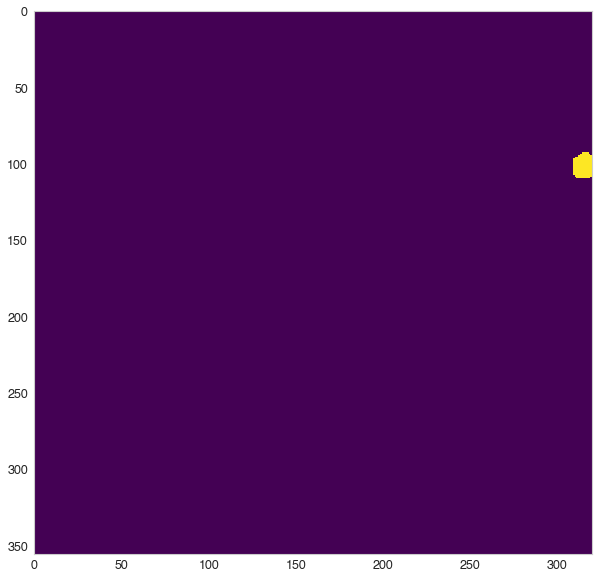

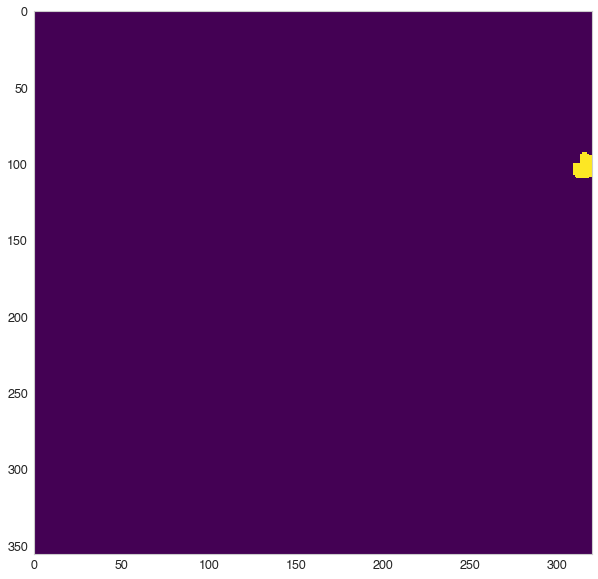

FINAL


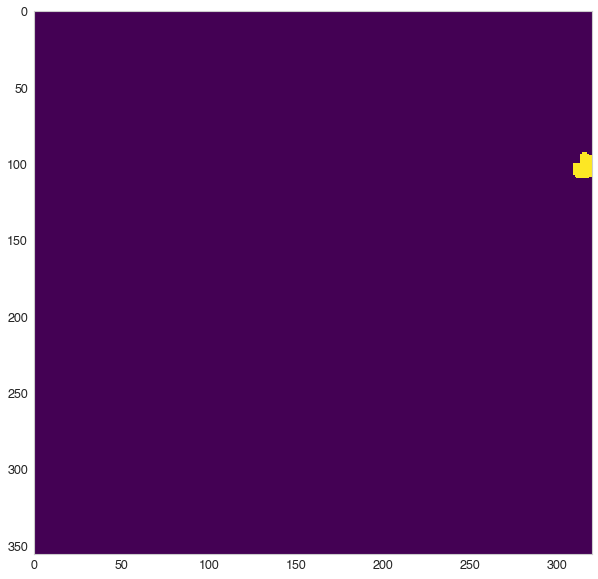

Done masking
Done creating pixels
Done clustering
penumbra
ORIGINAL


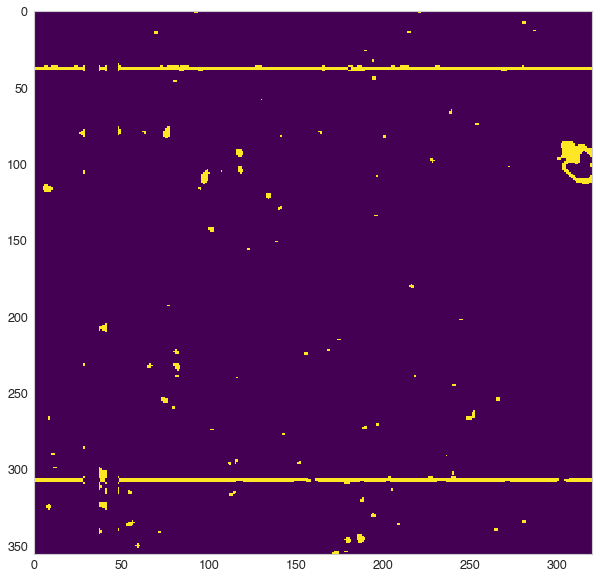

AFTER CLOSE


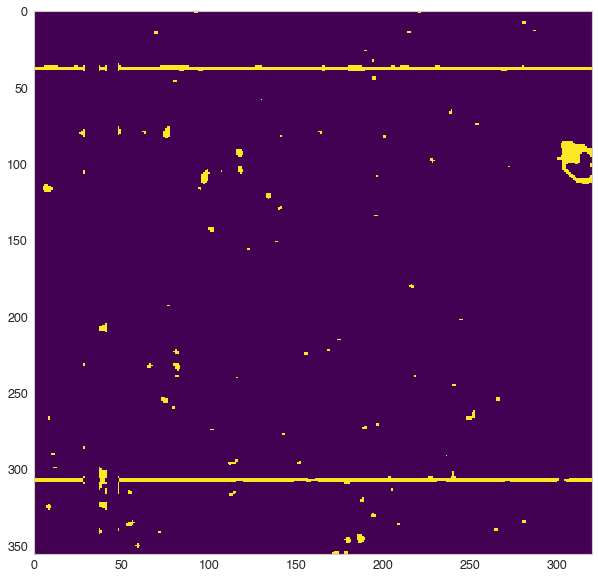

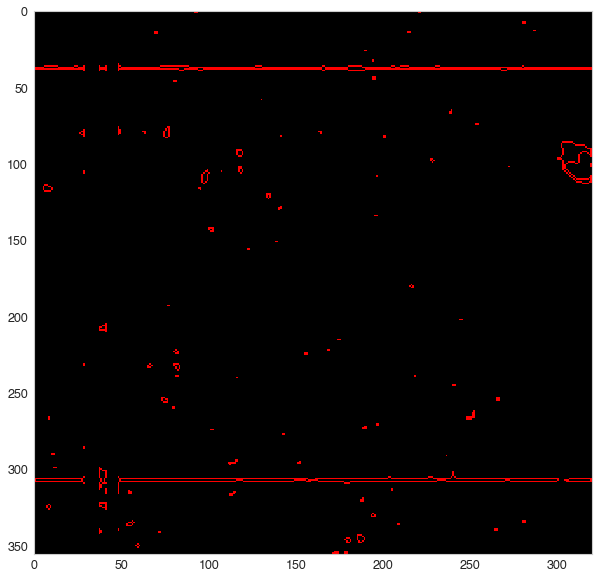

AFTER FILL


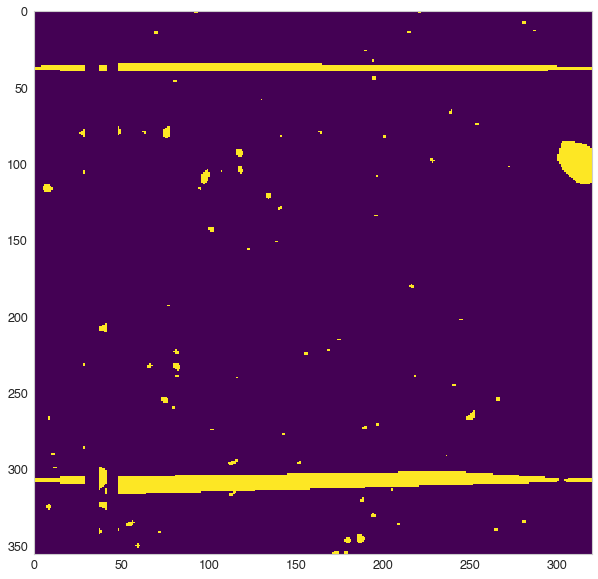

THRESH


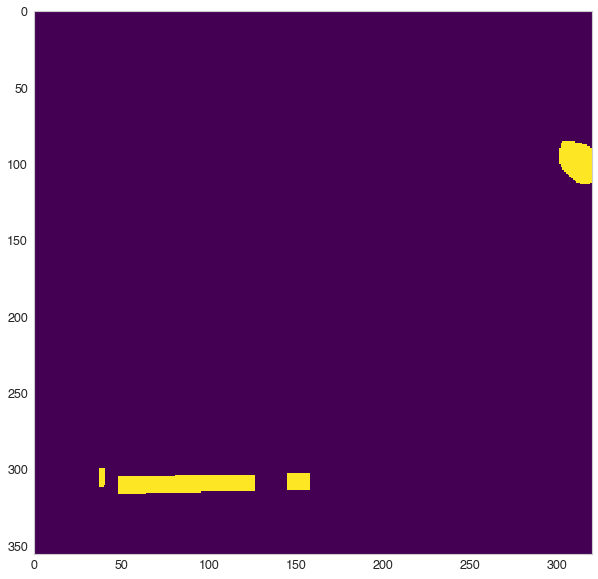

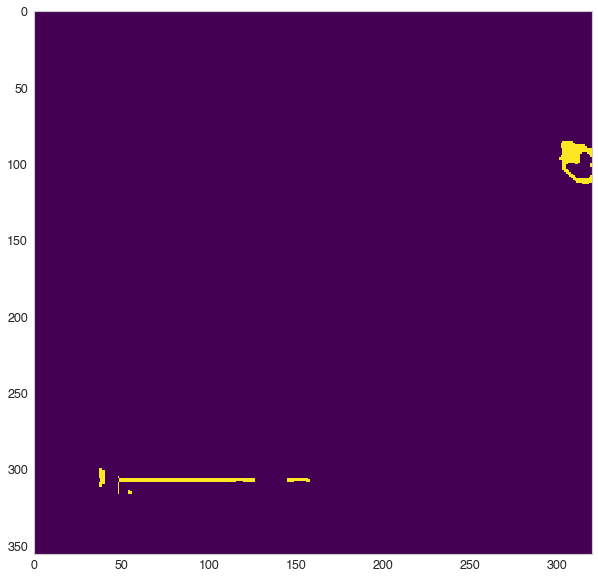

54 314 2 3 0.00625 0.008426966292134831 0.7416666666666667
1.5 113920 1.3167134831460674e-05
145 306 13 3 0.040625 0.008426966292134831 0.20743301642178044
23.5 113920 0.00020628511235955057
48 305 79 12 0.246875 0.033707865168539325 0.13653818802446308
507.0 113920 0.004450491573033708
37 300 4 12 0.0125 0.033707865168539325 0.37083333333333335
30.0 113920 0.0002633426966292135
319 100 1 3 0.003125 0.008426966292134831 0.37083333333333335
0.0 113920 0.0
301 86 19 28 0.059375 0.07865168539325842 0.7549107142857143
393.5 113920 0.003454178370786517


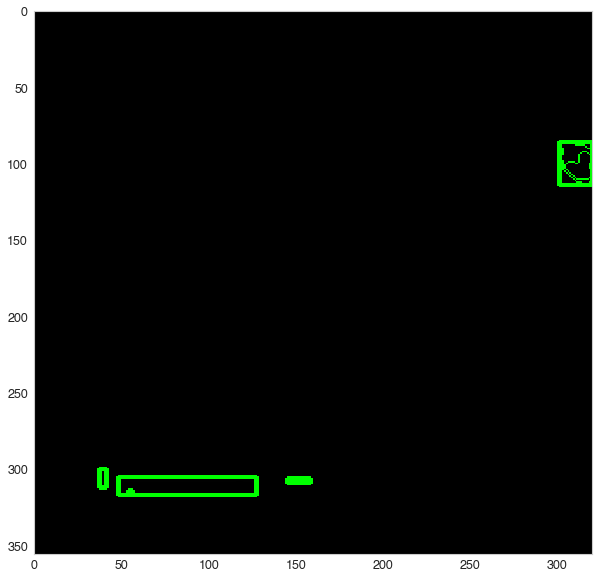

FINAL


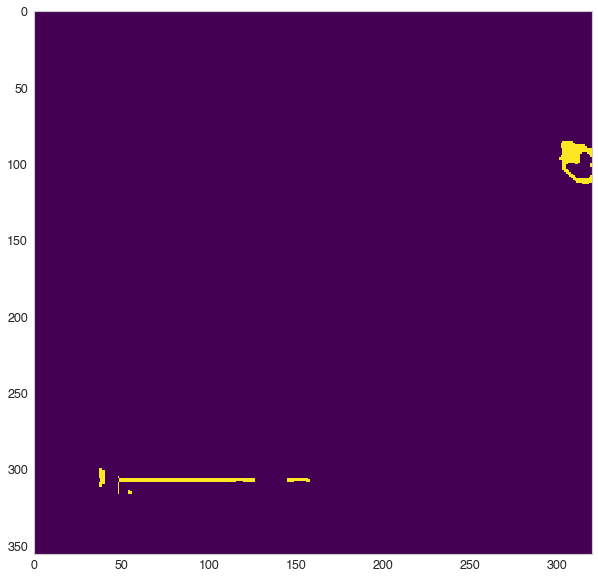

Done masking
Done creating pixels
Done clustering
super
ORIGINAL


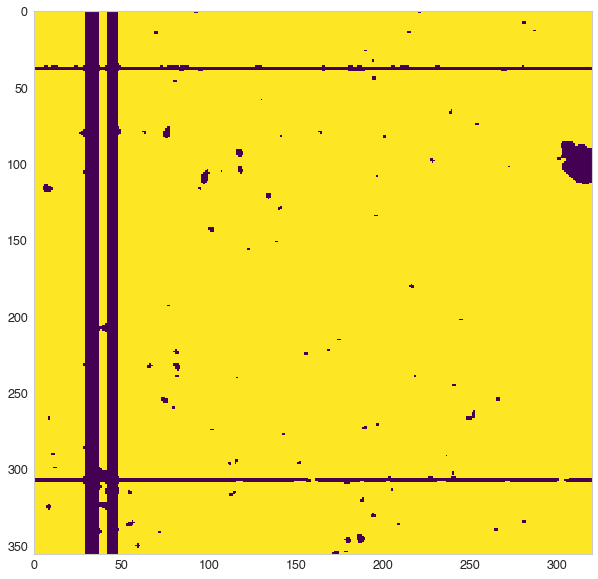

AFTER CLOSE


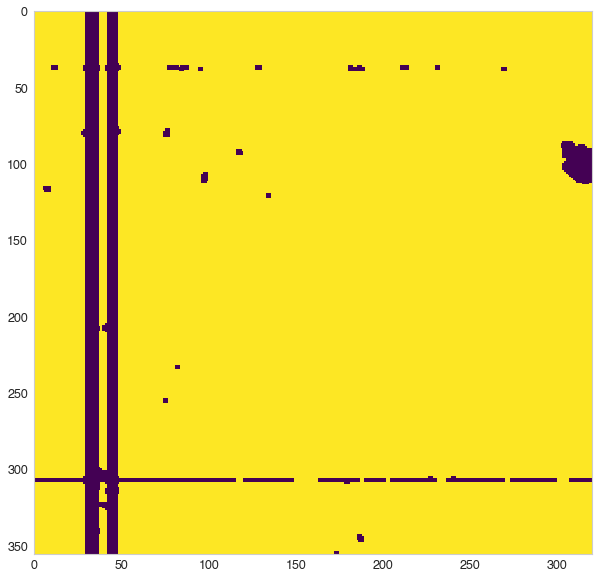

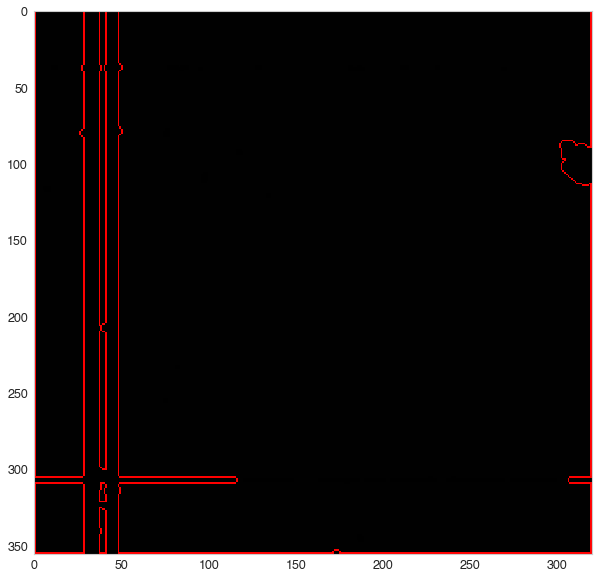

AFTER FILL


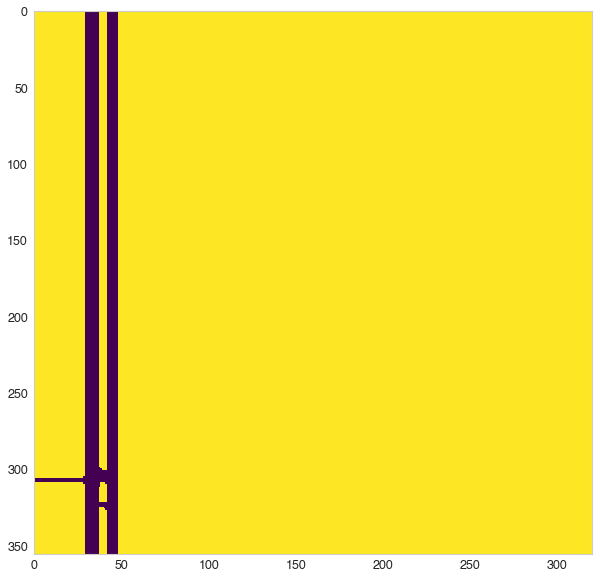

THRESH


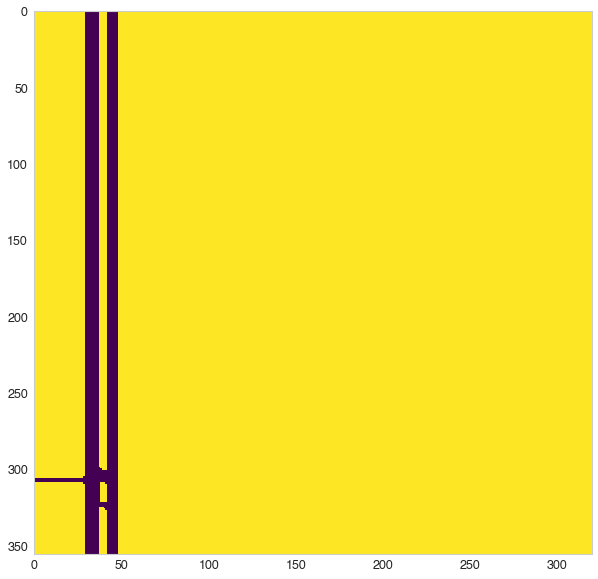

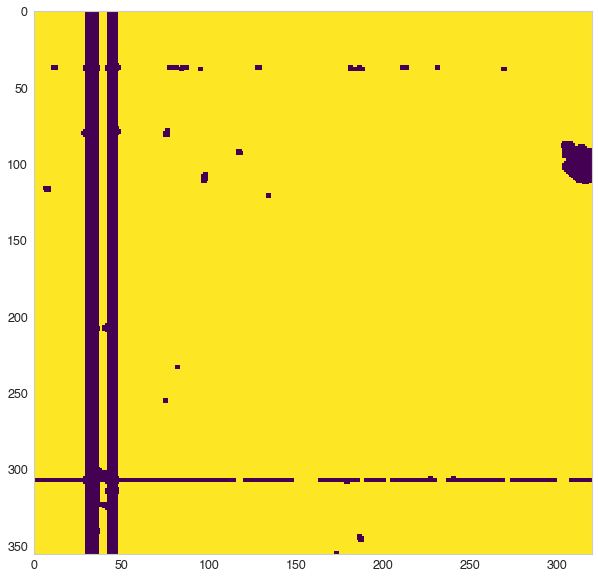

FINAL


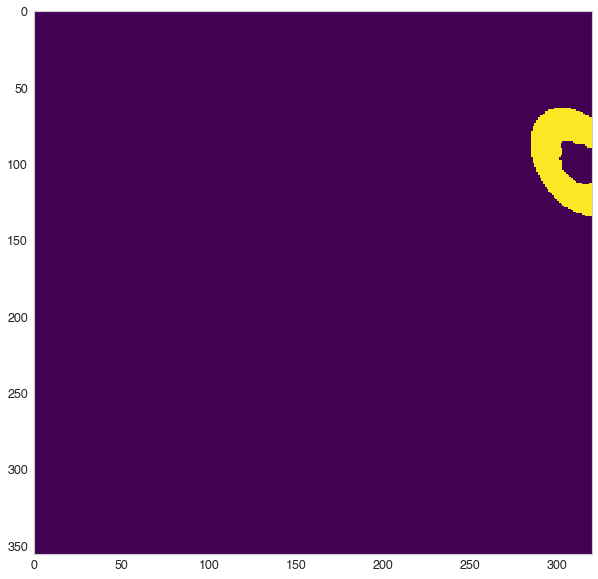

Done masking
Done creating pixels
Done clustering
quiet
ORIGINAL


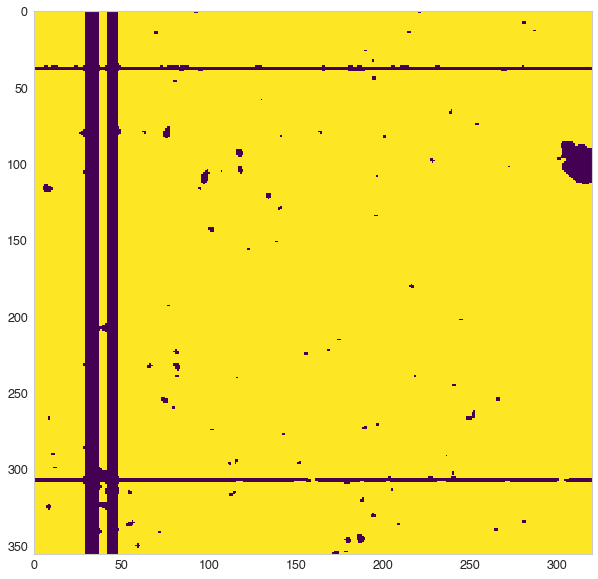

AFTER CLOSE


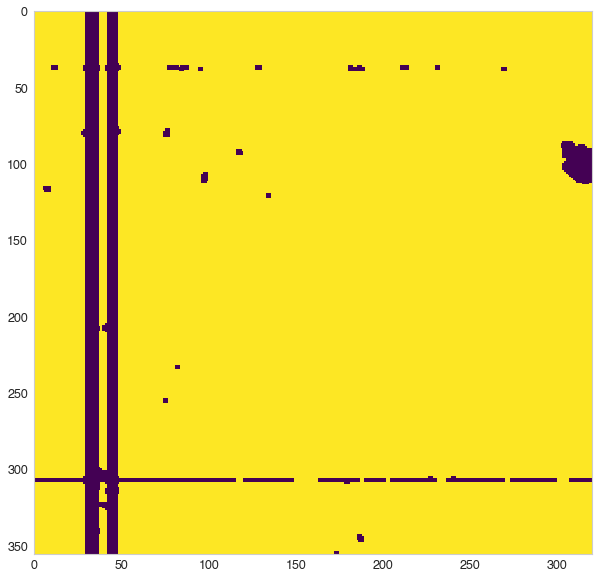

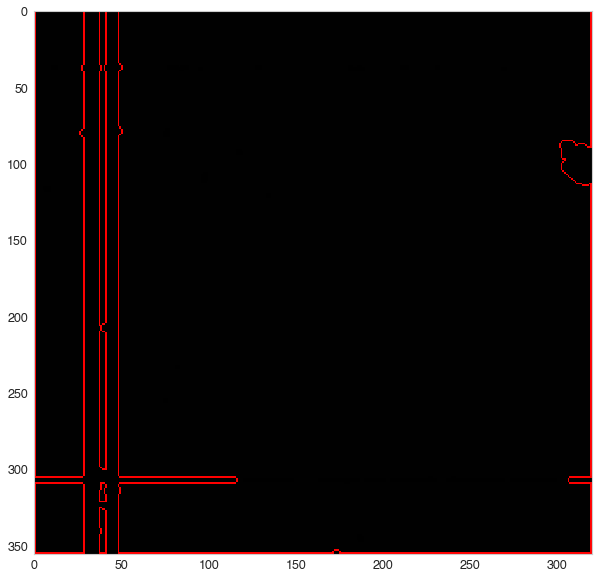

AFTER FILL


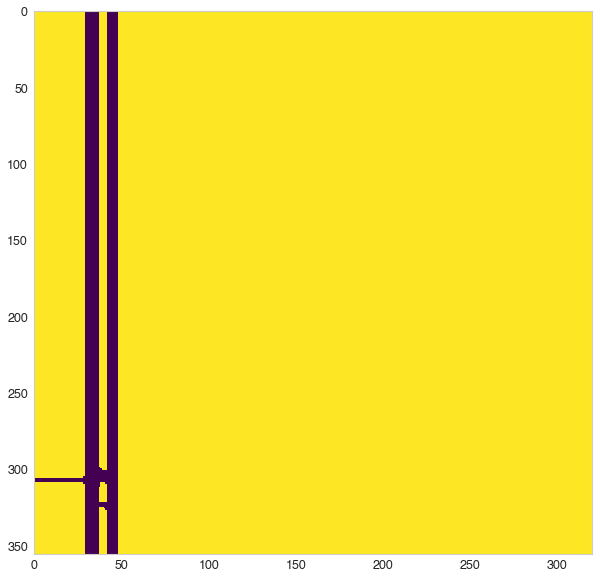

THRESH


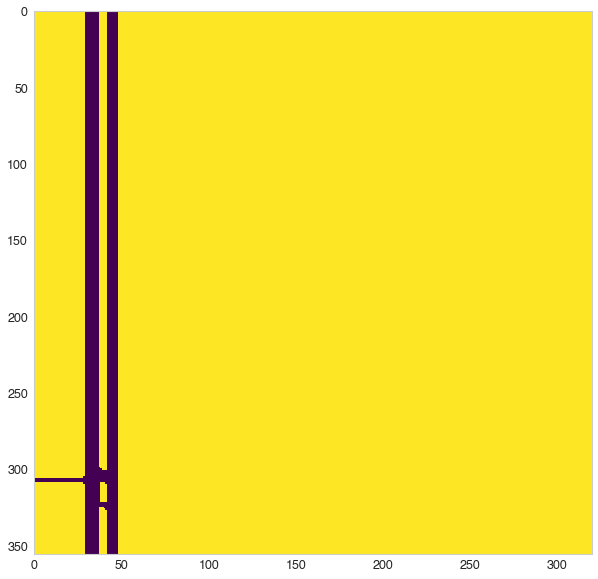

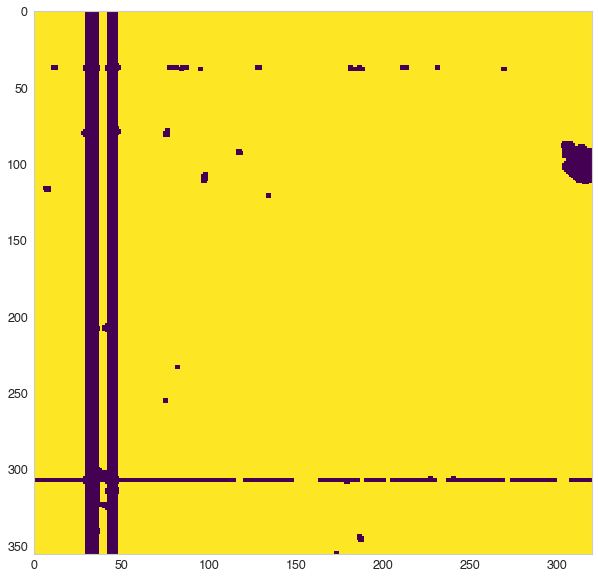

FINAL


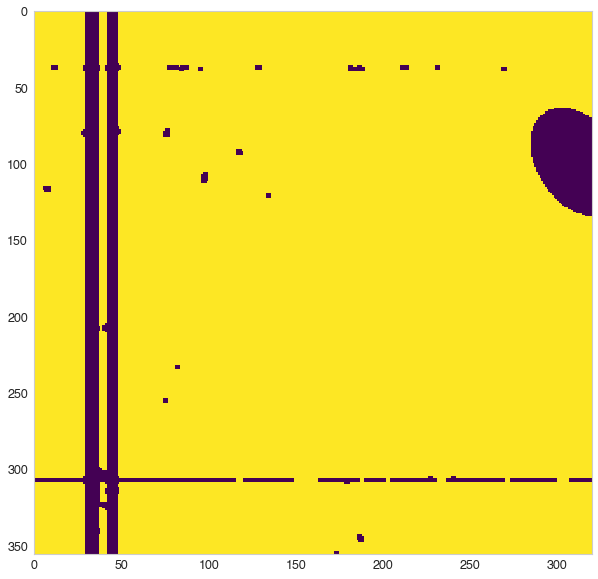

Done masking
Done creating pixels
Done clustering


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving...
kmap
kmap_sections
all_km


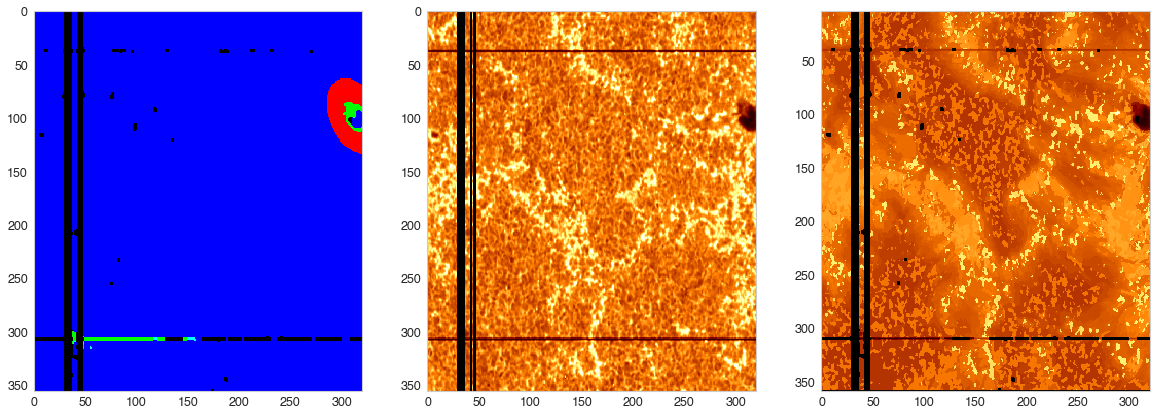

In [263]:
calculate_super = True

a = data[:, :, best-2:best+3].mean(axis=2)

black = np.where(a < 0)
black_mask = np.ones(shape=a.shape, dtype=np.uint8)
black_mask[black] = 0

m = a[np.where(a >= 0)].mean()

a = cv2.medianBlur(a, 3)
plt.imshow(a, aspect="auto", cmap=mgii.cmap)
plt.clim(0,climit)
plt.show()

area_thresholds = [0.3, 0.75]

mask_umbra = a < (m * area_thresholds[0])
mask_penumbra = (a > (m * area_thresholds[0])) & (a < (m * area_thresholds[1]))
mask_quiet = a > m * area_thresholds[1]
masks = [mask_umbra, mask_penumbra, mask_quiet]

if calculate_super:
    cluster_counts = [40, 60, 30, 30]
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 0, 255)]
    filenames = ['umbra', 'penumbra', 'super', 'quiet']
    masks.append(mask_quiet)
else:
    cluster_counts = [40, 60, 60]
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0)]
    filenames = ['umbra', 'penumbra', 'quiet']
    
res_masks = []

blank_image = np.zeros(shape=[*a.shape, 3], dtype=np.float32)
kmap = np.zeros(shape=[mgii.data.shape[0], mgii.data.shape[1], data_bounds[1]-data_bounds[0]])
kmap_sections = np.zeros(shape=[mgii.data.shape[0], mgii.data.shape[1], 1])
kmap_sections.fill(-1)

all_km = []
bad_data = False

for i, m in enumerate(masks):
    print(filenames[i])
    w = np.where(m, a, 0)
    
    if calculate_super and res_masks:
        res = run_clustering(w, cluster_counts[i], filenames[i]+'.png', kmap, 
                             kmap_sections, i, False, black_mask, res_masks[i-2])
    else:
        res = run_clustering(w, cluster_counts[i], filenames[i]+'.png', kmap, 
                      
                             kmap_sections, i, filenames[i]=='penumbra', black_mask)

    if res is None:
        bad_data = True
        break
        
    mask, sp, quiet, km = res
  
    if sp is not None and calculate_super:
        res_masks.extend([sp, quiet])
        
    rgb = cv2.cvtColor(mask,cv2.COLOR_GRAY2RGB)
    rgb[mask > 0] = colors[i]
    blank_image = cv2.bitwise_or(blank_image, rgb)
    all_km.append(km)

f, axes = plt.subplots(1, 3, figsize=(20,7))
axes[0].imshow(blank_image, aspect="auto")
implot = axes[1].imshow(data[:, :, best], aspect="auto", cmap=mgii.cmap)
implot.set_clim([0, climit])
kmapplot = axes[2].imshow(kmap[:, :, 0], aspect="auto", cmap=mgii.cmap)
kmapplot.set_clim([0, climit/1.5])
axes[2].set_ylim(bounds[::-1])
plt.savefig(dir_name + '/segmented.png')

if not bad_data:
    save_filename = dir_name + "/" + 'kmeans_data.jbl.gz'
    sv.save(save_filename, kmap, kmap_sections, all_km, force=True)

In [265]:
del iris_raster, mgii, data

NameError: name 'iris_raster' is not defined